In [244]:
def InitialiseParam_BS( Values, current_time_idx, r, div, sigma, dt, Smax, T, K ):
    N = len(Values);
    a = [0]*N;
    b = [0]*N;
    c = [0]*N;
    d = [0]*N;
    #print(dt, r, -1/dt - 0.5 *r )
    for j in range(0, N, 1):
        if j == 0: 
            a[0] = 0;
            b[0] = 1;#-1/dt - 0.5*r;#lower boundary condition
            c[0] = 0;
            d[0] = 0;#( -1/dt + 0.5*r )*Values[0][ current_time_idx+1 ];
        elif j == N-1:
            a[j] = 0;
            b[j] = 1;
            c[j] = 0;
            d[j] = Smax*numpy.exp(-div*(T-current_time_idx*dt)) - K*numpy.exp(-r*(T-current_time_idx*dt));#upper bounray condition
            #print( j, a[j], b[j], c[j], d[j], '\n');
        else:
            a[j] = -0.25*j*(r-div) + 0.25*sigma*sigma*j*j;
            b[j] = -1/dt - 1/2*sigma*sigma*j*j - 1/2*r;
            c[j] = +0.25*j*(r-div) + 0.25*sigma*sigma*j*j;
            
            d1 = ( 0.25*j*(r-div) - 0.25*sigma*sigma*j*j )*Values[j-1][current_time_idx+1];
            d2 = (-1/dt + 1/2*sigma*sigma*j*j + 0.5*r )*Values[j][current_time_idx+1];
            d3 = (-0.25*j*(r-div) - 0.25*sigma*sigma*j*j )*Values[j+1][current_time_idx+1];
            d[j] = d1 + d2 + d3;
                
    return a,b,c,d

In [243]:
#tested
def SOR_solver( a, b, c, d, initial_guess, IterMax = 1000, tol = 1.e-8 ):
    N = len(a);
    omega = 0.8;
    result = initial_guess[:];# create a copy
    for sor in range( IterMax ):
        err = 0;
        y = (d[0] - c[0]*result[1])/b[0];
        #print( d[0], c[0], b[0] );
        err += abs(y);
        result[0] = result[0] + omega*( y - result[0] );
        
        for j in range( 1, N-1, 1 ):
            y = ( d[ j ] - a[ j ] * result[j-1] - c[ j ] * result[ j + 1 ] )/b [ j ];
            err += abs(y);
            result[ j ] = result[ j ] + omega *( y - result[ j ] );
        
        y = ( d[N-1] - a[ N-1 ] * result[N-2]) /b[ N-1 ] ;
        err += abs(y);
        result[ N-1 ] = result[ N-1 ] + omega*(y - result[ N-1 ] );
        
        
        if err < tol:
            break
    return result

In [375]:
def BSOptionPDESolver( S, rate, div, sigma, K, T, S_grid_size, T_grid_size, Smax ):
    ds = Smax/S_grid_size;
    dt = T/T_grid_size;
    print( 'Grid boundary: S ', 0, '->', Smax, ' T ', 0, ' -> ', T );
    print( 'Grid Sizes: S ', S_grid_size, ', T ', T_grid_size );
    print( 'Step size: S ', ds, ', T ', dt);
    
    #initialise grid and mesh
    S_grid = [j*ds for j in range(0,S_grid_size+1,1)];
    T_grid = [i*dt for i in range(0,T_grid_size+1,1)];
    
    mesh = numpy.zeros([S_grid_size+1,T_grid_size+1] ,dtype = float );
    for j in range(0,S_grid_size+1,1):
        mesh[j][T_grid_size]= max(S_grid[j] - K , 0 );#initial condition
        
    for i in range( T_grid_size-1, -1, -1 ):
        a,b,c,d = InitialiseParam_BS( mesh, i, rate, div, sigma, dt, Smax,T,K );
        initial_guess = [ mesh[j][i+1] for j in range(len(mesh))];#solution at t+1
        #print( 'Solving Time to maturity ', dt*i );
        solution = SOR_solver(a,b,c,d, initial_guess);
        for j in range( 0, len(solution), 1 ):
            mesh[j][i] = solution[j];
            
    prices = [ mesh[j][0] for j in range(len(mesh))];
    price  = numpy.interp(S, S_grid, prices);
    #print( 'Price ', price )
    return price

In [ ]:
def BS_Analytic( S, rate, div, sigma, K, T, optiontype = 'Call' ):
    d1 = (numpy.log(S/K) + (rate - div + 0.5*sigma*sigma )*T )/(sigma *sqrt((T)));
    d2 = d1 - sigma*sqrt(T);
    if optionstyle == 'Call':
        return = S*numpy.exp(-div*T)*stats.norm.cdf(d1) - K*numpy.exp(-rate*T)*stats.norm.cdf(d2);
    elif optionstyle == 'Put':
        return = K*numpy.exp(-rate*T)*stats.norm.cdf(-d2) - S*numpy.exp(-div*T)*stats.norm.cdf(-d1)
    else:
        sys.exit('undefined')

In [ ]:
import math
import numpy
import sys
import pdb
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
S = 100;
rate = 0.02;
div = 0.04;
T=3;
K=S;
sigma = 0.3;
S,K, div, T, sigma

In [255]:
Smax = K*4;
S_step_N = pow(10,3);
T_step_M = pow(10,3);
ds = Smax/S_step_N;
dt = T/T_step_M;
Smax,S_step_N, T, ds, dt

(400, 1000, 3, 0.4, 0.003)

In [256]:
S_grid = [j*ds for j in range(0,S_step_N+1,1)];
T_grid = [i*dt for i in range(0,T_step_M+1,1)];

In [257]:
mesh = numpy.zeros([S_step_N+1,T_step_M+1] ,dtype = float );
for j in range(0,S_step_N+1,1):
    mesh[j][T_step_M]= max(S_grid[j] - K , 0 );#initial condition

In [258]:
for i in range( T_step_M-1, -1, -1 ):
    a,b,c,d = InitialiseParam_BS( mesh, i, rate, div, sigma, dt, Smax,T,K );
    initial_guess = [ mesh[j][i+1] for j in range(len(mesh))];#solution at t+1
    solution = SOR_solver(a,b,c,d, initial_guess);
    
    for j in range( 0, len(solution), 1 ):
        mesh[j][i] = solution[j];

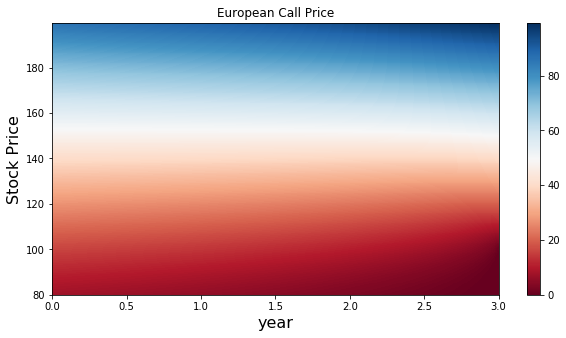

In [345]:
fig, ax = plt.subplots( )
x = T_grid ;
y = S_grid[200:500];
z = mesh[200:500];
c = ax.pcolormesh( x, y, z, cmap='RdBu' )
ax.set_title('European Call Price')
plt.xlabel('year',fontsize=16 );
plt.ylabel('Stock Price',fontsize=16);
fig.colorbar(c, ax=ax)
fig.set_size_inches(10, 5);
plt.show()
fig.savefig('ECallPriceMesh.png', dpi=100)

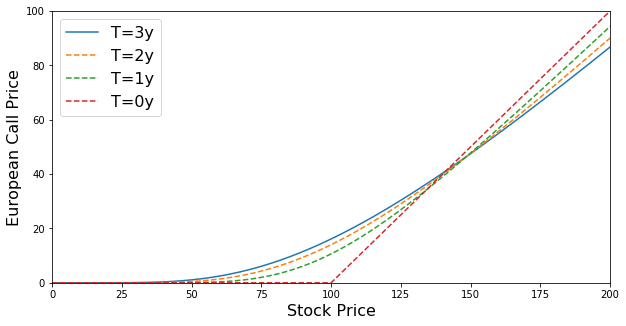

In [319]:
fig, ax2 = plt.subplots( )
ax2.plot( S_grid, [ mesh[j][0] for j in range(len(mesh))], label = 'T=3y' )
ax2.plot( S_grid, [ mesh[j][333] for j in range(len(mesh))], '--', label='T=2y' )
ax2.plot( S_grid, [ mesh[j][666] for j in range(len(mesh))], '--', label='T=1y' )
ax2.plot( S_grid, [ mesh[j][1000] for j in range(len(mesh))], '--', label='T=0y' )

ax.set_title('Call Price vs Time to Maturity')
plt.xlabel('Stock Price', fontsize=16 );
plt.ylabel('European Call Price',fontsize=16 );
plt.xlim([0,200]);
plt.ylim([0,100]);
plt.legend( loc='upper left', prop={'size': 16} )
fig.set_size_inches(10, 5);
plt.show()
fig.savefig('EuropeanCallPrice.png', dpi=100)

In [386]:
S_grid_sizes = [100, 200, 400, 800, 1600];
T_grid_sizes = [100, 200, 400, 800, 1600];
convergence = numpy.zeros( [len(S_grid_sizes), len(S_grid_sizes)],dtype = float );

In [ ]:
for s in range(len(S_grid_sizes)):
    s_size = S_grid_sizes[s];
    for t in range(len(T_grid_sizes)):
        t_size = T_grid_sizes[t];
        price = BSOptionPDESolver( S, rate, div, sigma, K, T, s_size, t_size, 4*S );
        print(s_size , t_size, price);
        convergence[s][t] = price;

Grid boundary: S  0 -> 400  T  0  ->  3
Grid Sizes: S  100 , T  100
Step size: S  4.0 , T  0.03
100 100 16.110069671197166
Grid boundary: S  0 -> 400  T  0  ->  3
Grid Sizes: S  100 , T  200
Step size: S  4.0 , T  0.015
100 200 16.110015827658955
Grid boundary: S  0 -> 400  T  0  ->  3
Grid Sizes: S  100 , T  400
Step size: S  4.0 , T  0.0075
100 400 16.110002366395978
Grid boundary: S  0 -> 400  T  0  ->  3
Grid Sizes: S  100 , T  800
Step size: S  4.0 , T  0.00375
100 800 16.109999001056927
Grid boundary: S  0 -> 400  T  0  ->  3
Grid Sizes: S  100 , T  1600
Step size: S  4.0 , T  0.001875
100 1600 16.10999815972075
Grid boundary: S  0 -> 400  T  0  ->  3
Grid Sizes: S  200 , T  100
Step size: S  2.0 , T  0.03
200 100 16.119589254025797
Grid boundary: S  0 -> 400  T  0  ->  3
Grid Sizes: S  200 , T  200
Step size: S  2.0 , T  0.015
200 200 16.11953555191474
Grid boundary: S  0 -> 400  T  0  ->  3
Grid Sizes: S  200 , T  400
Step size: S  2.0 , T  0.0075
200 400 16.119522126012214
Gri

In [383]:
for j in range(len(mesh)):
    print( S_grid[j], mesh[j][0])

0.0 0.0
0.4 4.327928204525223e-21
0.8 1.3324771570814562e-18
1.2000000000000002 8.753417082535748e-17
1.6 2.4331071194243725e-15
2.0 3.761888080881112e-14
2.4000000000000004 3.771206442169606e-13
2.8000000000000003 2.708538442479508e-12
3.2 1.4951783049336793e-11
3.6 6.680336860471597e-11
4.0 2.511866146672139e-10
4.4 8.190662260038511e-10
4.800000000000001 2.3710262329730424e-09
5.2 6.207103573540105e-09
5.6000000000000005 1.4914518025894356e-08
6.0 3.3288942718546244e-08
6.4 6.969692825027156e-08
6.800000000000001 1.3799370319406154e-07
7.2 2.6011115876850996e-07
7.6000000000000005 4.694253463603321e-07
8.0 8.150017503042719e-07
8.4 1.366800793589633e-06
8.8 2.2219065639623667e-06
9.200000000000001 3.511819778483299e-06
9.600000000000001 5.410832690540324e-06
10.0 8.145480051113462e-06
10.4 1.200503729476492e-05
10.8 1.7353015595230116e-05
11.200000000000001 2.463958391765011e-05
11.600000000000001 3.4414831108086716e-05
12.0 4.734276667466063e-05
12.4 6.421594736077577e-05
12.8 8.59